In [ ]:
#Install
!pip install -U scikit-learn

In [ ]:
#Import
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_percentage_error, r2_score

In [ ]:
#Download File
!wget -nc https://lazyprogrammer.me/course_files/airline_passengers.csv

--2022-01-06 09:55:24--  https://lazyprogrammer.me/course_files/airline_passengers.csv
Resolving lazyprogrammer.me (lazyprogrammer.me)... 172.67.213.166, 104.21.23.210, 2606:4700:3031::6815:17d2, ...
Connecting to lazyprogrammer.me (lazyprogrammer.me)|172.67.213.166|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2036 (2.0K) [text/csv]
Saving to: ‘airline_passengers.csv’

airline_passengers. 100%[===================>]   1.99K  --.-KB/s    in 0s      

2022-01-06 09:55:25 (18.5 MB/s) - ‘airline_passengers.csv’ saved [2036/2036]



In [ ]:
#Buat dataframe
df = pd.read_csv('airline_passengers.csv', index_col='Month', parse_dates=True)

#Buat kolom baru di dataframe
df['LogPassengers'] = np.log(df['Passengers'])

#Buat variable baru untuk data training dan testing
Ntest = 12
train = df.iloc[:-Ntest] # data < tail(12)
test = df.iloc[-Ntest:] # data = tail(12)

# Buat supervised dataset, dan lihat apakah kita dapat menggunakan nilai "T-past" untuk memprediksi nilai selanjutnya?
series = df['LogPassengers'].to_numpy()

#Buat variable
T = 10
X = [] # array X
Y = [] # array Y

#Buat perulangan
for t in range(len(series) - T):
  x = series[t:t+T]
  X.append(x)
  y = series[t+T]
  Y.append(y)

#Ubah menjadi ndarray, dan lakukan reshape
X = np.array(X).reshape(-1, T)
Y = np.array(Y)
N = len(X)
print("X.shape:", X.shape, "Y.shape:", Y.shape)

X.shape: (134, 10) Y.shape: (134,)


In [ ]:
#Buat Variable untuk data training dan testing
Xtrain, Ytrain = X[:-Ntest], Y[:-Ntest]
Xtest, Ytest = X[-Ntest:], Y[-Ntest:]

# Linear Regression

In [ ]:
#Buat model
lr = LinearRegression()

#Fit model
lr.fit(Xtrain, Ytrain)

#Display score dari model
print("Score model untuk data training:", lr.score(Xtrain, Ytrain))
print("Score model untuk data testing:", lr.score(Xtest, Ytest))

Score model untuk data training: 0.9599443783339898
Score model untuk data testing: 0.6910953044565602


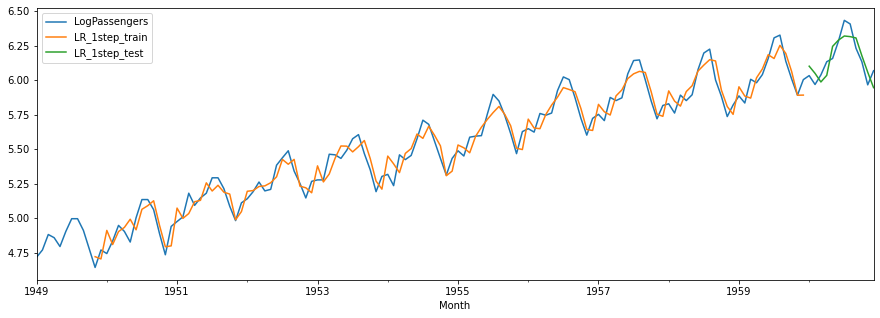

In [ ]:
#Boolean index
#Buat variable
train_idx = df.index <= train.index[-1]
test_idx = ~train_idx

train_idx[:T] = False # nilai T pertama tidak dapat diprediksi

#1-step forecast
df.loc[train_idx, 'LR_1step_train'] = lr.predict(Xtrain)
df.loc[test_idx, 'LR_1step_test'] = lr.predict(Xtest)

#Plot dari 1-step forecast
df[['LogPassengers', 'LR_1step_train', 'LR_1step_test']].plot(figsize=(15, 5));

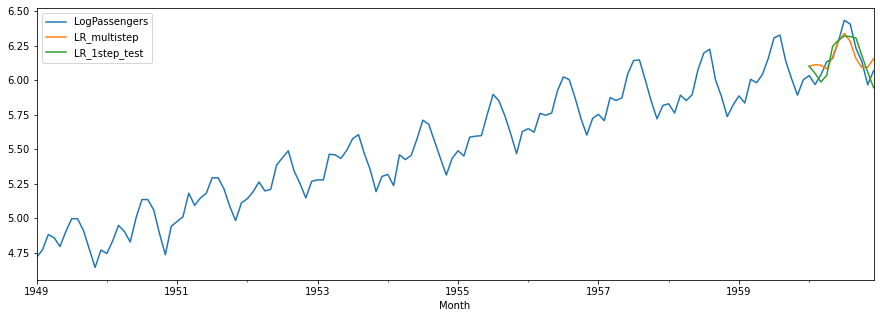

In [ ]:
#Multi-step forecast
multistep_predictions = []

#Input data testing pertama (index=0)
last_x = Xtest[0]

#Buat perulangan
while len(multistep_predictions) < Ntest:
  p = lr.predict(last_x.reshape(1, -1))[0]
  
  #Update predictions list
  multistep_predictions.append(p)
  
  #Buat inputan baru
  last_x = np.roll(last_x, -1)
  last_x[-1] = p

#Simpan multi-step forecast ke dalam dataframe
df.loc[test_idx, 'LR_multistep'] = multistep_predictions

#Buat plot 1-step forecast dan multi-step forecast
df[['LogPassengers', 'LR_multistep', 'LR_1step_test']].plot(figsize=(15, 5));

In [ ]:
#Buat multi-output supervised dataset

#Buat variable
Tx = T
Ty = Ntest

#Buat array
X = []
Y = []

#Buat perulangan
for t in range(len(series) - Tx - Ty + 1):
  x = series[t:t+Tx]
  X.append(x)
  y = series[t+Tx:t+Tx+Ty]
  Y.append(y)

#Buat variable
X = np.array(X).reshape(-1, Tx)
Y = np.array(Y).reshape(-1, Ty)
N = len(X)

#Display
print("X.shape", X.shape, "Y.shape", Y.shape)

X.shape (123, 10) Y.shape (123, 12)


In [ ]:
#Buat variable untuk data training dan testing
Xtrain_m, Ytrain_m = X[:-1], Y[:-1]
Xtest_m, Ytest_m = X[-1:], Y[-1:]

#Buat model
lr = LinearRegression()

#Fit model
lr.fit(Xtrain_m, Ytrain_m)

#Tampilkan score model untuk data training
print("Score model untuk data training terbaru:", lr.score(Xtrain_m, Ytrain_m))

Score model untuk data training terbaru: 0.9734607773512528


In [ ]:
# SST = 0
lr.score(Xtest_m, Ytest_m)

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


nan

In [ ]:
#Hitung score r2
print("Score R2:", r2_score(lr.predict(Xtest_m).flatten(), Ytest_m.flatten()))

Score R2: 0.8018749676715189


In [ ]:
#Simpan multi-output forecast ke dalam dataframe
df.loc[test_idx, 'LR_multioutput'] = lr.predict(Xtest_m).flatten()

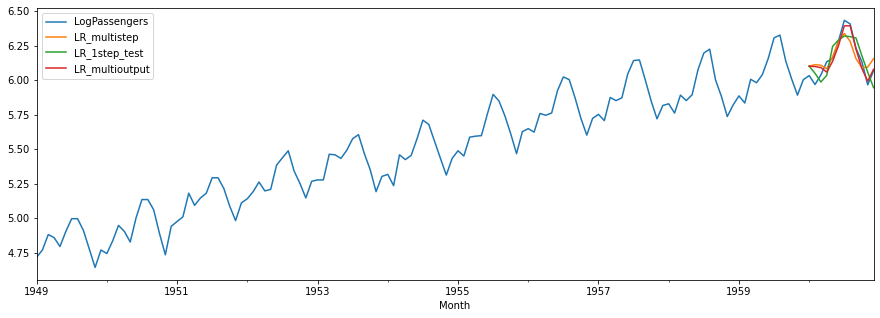

In [ ]:
#Plot untuk semua forecast
cols = ['LogPassengers', 'LR_multistep', 'LR_1step_test', 'LR_multioutput']
df[cols].plot(figsize=(15, 5));

In [ ]:
#Hitung MAPE
mape1 = mean_absolute_percentage_error(Ytest, multistep_predictions)
print("multi-step MAPE:", mape1)
mape2 = mean_absolute_percentage_error(Ytest, df.loc[test_idx, 'LR_multioutput'])
print("multi-output MAPE:", mape2)

multi-step MAPE: 0.012229325023475299
multi-output MAPE: 0.007178924475039815


# Tes menggunakan model lain

In [ ]:
#Buat fungsi
def one_step_and_multistep_forecast(model, name):
  #Fit model
  model.fit(Xtrain, Ytrain)
  
  #Display 1-step forecast
  print("1-step forecast:", name)
  
  #Display r2 score untuk data training dari 1-step forecast
  print("Train R^2:", model.score(Xtrain, Ytrain))

  #Display r2 score untuk data testing dari 1-step forecast
  print("Test R^2 (1-step):", model.score(Xtest, Ytest))

  #1-step forecast
  df.loc[train_idx, f'{name}_1step_train'] = model.predict(Xtrain)
  df.loc[test_idx, f'{name}_1step_test'] = model.predict(Xtest)

  #Buat multi-step forecast
  multistep_predictions = []

  #Lakukan input dengan menggunakan data testing pertama (index=0)
  last_x = Xtest[0]

  #Buat perulangan
  while len(multistep_predictions) < Ntest:
    p = model.predict(last_x.reshape(1, -1))[0]
    
    #Update predictions list
    multistep_predictions.append(p)
    
    #Buat inputan terbaru
    last_x = np.roll(last_x, -1)
    last_x[-1] = p
  
  #Multi-step forecast
  df.loc[test_idx, f'{name}_multistep_test'] = multistep_predictions

  #MAPE multi-step forecast
  mape = mean_absolute_percentage_error(Ytest, multistep_predictions)
  print("Test MAPE (multi-step):", mape)

  #Plot 1-step dan multi-step forecast
  cols = [
    'LogPassengers',
    f'{name}_1step_train',
    f'{name}_1step_test',
    f'{name}_multistep_test'
  ]
  df[cols].plot(figsize=(15, 5));

1-step forecast: SVR
Train R^2: 0.9620706864124723
Test R^2 (1-step): 0.34759277730706106
Test MAPE (multi-step): 0.017529446164230467


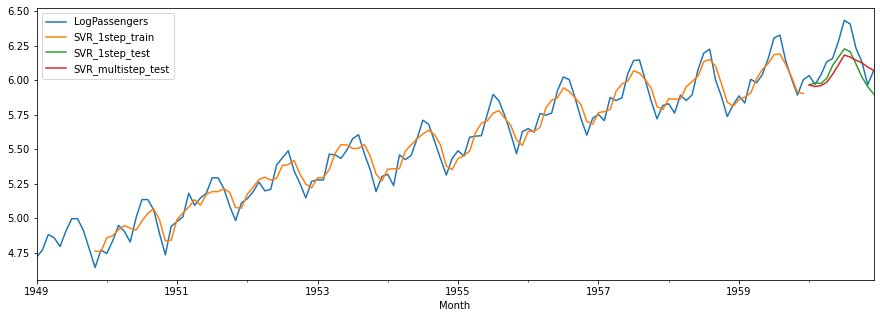

In [ ]:
#Tes fungsi di atas dgn menggunakan SVR
one_step_and_multistep_forecast(SVR(), "SVR")

1-step forecast: RF
Train R^2: 0.9888116872151789
Test R^2 (1-step): 0.28970274676548546
Test MAPE (multi-step): 0.029643735862785046


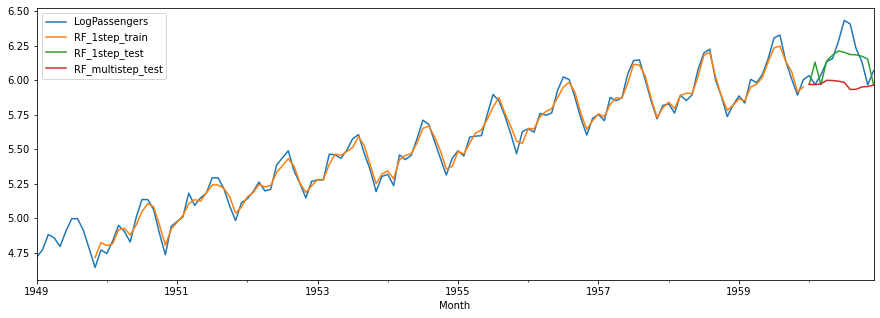

In [ ]:
#Tes fungsi di atas menggunakan RF
one_step_and_multistep_forecast(RandomForestRegressor(), "RF")

In [ ]:
#Buat fungsi kedua
def multi_output_forecast(model, name):
  #Buat model
  model.fit(Xtrain_m, Ytrain_m)
  
  #Simpan multi-output forecast ke dalam dataframe
  df.loc[test_idx, f'{name}_multioutput'] = model.predict(Xtest_m).flatten()

  #Hitung MAPE
  mape = mean_absolute_percentage_error(Ytest, df.loc[test_idx, f'{name}_multioutput'])
  #Display MAPE
  print("Test MAPE (multi-output):", mape)

  #Plot semua forecasts
  #Asumsikan bahwa fungsi sebelumnya telah dijalankan
  cols = [
    'LogPassengers',
    f'{name}_1step_train',
    f'{name}_1step_test',
    f'{name}_multistep_test',
    f'{name}_multioutput',
  ]
  df[cols].plot(figsize=(15, 5));

In [ ]:
multi_output_forecast(SVR(), "SVR")

ValueError: ignored

# Error di atas menandakan bahwa tidak dapat menangani multi-output pada SVR, tetapi kita masih dapat mencoba dengan menggunakan RandomForestRegression seperi di bawah ini.

Test MAPE (multi-output): 0.01667337891212128


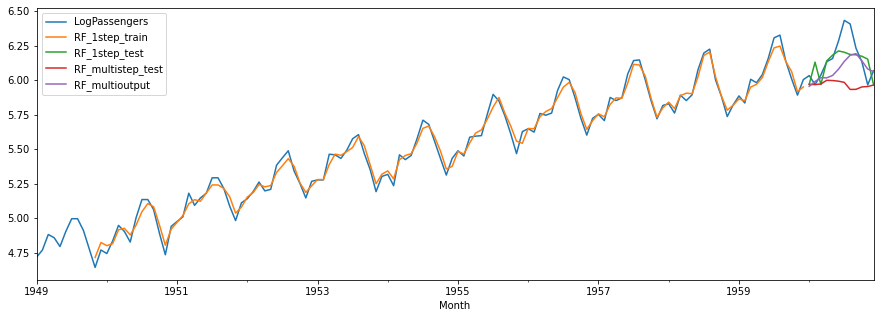

In [ ]:
#Tes fungsi di atas menggunakan RF
multi_output_forecast(RandomForestRegressor(), "RF")

In [ ]:
# Exercise: compute MAPE for non-logged data (i.e. exponentiate predictions)
# Compare with previous models (e.g. ARIMA, ETS)